# Datos Masivos 
## Mini-Proyecto 1: Modelado de Tópicos

**Presentado por**

* Acosta Imandt Daniel 
* Castillo del Valle Pablo David 
* Cruz Larios Marcela
* Lara Moreno Yeudiel

El objetivo de este proyecto es extraer y visualizar los tópicos de los datos sobre el consumo de algunas medicinas para ciertas condiciones medicas, esto con el algoritmo de reducción de dimensionalidad  SVD truncado.

## Librerías y datos

In [ ]:
#Instalar bibliotecas
!pip install WordCloud
!pip install contractions
!pip install texthero
!pip install install pyldavis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 458.6/458.6 KB 9.6 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.5/287.5 KB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.4/109.4 KB 13.5 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 KB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 23.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.2/184.2 KB 22.6 MB/s eta 0:00:00
  Created wheel for gensim: filename=gensim-3.8.3-cp39-cp39-linux_x86_64.whl size=24259433 sha256=b4f37240bf2c2ce

In [ ]:
#Manipulación de datos
import numpy as np
import pandas as pd
from math import ceil

#Eliminar warnings 
import warnings

#Gráficas
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import pyLDAvis
import pyLDAvis.sklearn

#Procesamiento de Texto
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import texthero as hero
import contractions
from html import unescape
import spacy

#Modelo 
# Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils.extmath import randomized_svd


#Configuraciones
wordnet_lemmatizer = WordNetLemmatizer()
nltk.download('omw-1.4')
nltk.download('wordnet')
stop_words = stopwords.words('english')
plt.style.use('fivethirtyeight')
warnings.filterwarnings("ignore")

/shared-libs/python3.9/py/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/root/venv/lib/python3.9/site-packages/gensim/matutils.py:24: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 51.5 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for en_core_web_sm: filename=en_core_web_sm-2.3.1-py3-none-any.whl size=12047105 sha256=b9e77a1ba635c8cf6bb8a03107adc4757ee06c9c70b6982844ee9d98c5e5a656
  Stored in directory: /root/.cache/pip/wheels/19/d6/1c/5484b9

In [ ]:
#Leemos los dos csv que contienen los datos. 
df = pd.read_csv('drugsComTrain_raw.csv')
df_2 = pd.read_csv('drugsComTest_raw.csv')

In [ ]:
#Concatenamos los dataframe
df = pd.concat([df, df_2], ignore_index=True).reset_index(drop=True) 

In [ ]:
#Tenemos 7 columnas con 215063 registros. 
df.shape

(215063, 7)

In [ ]:
df.head()

uniqueID                  drugName                     condition  \
0    206461                 Valsartan  Left Ventricular Dysfunction   
1     95260                Guanfacine                          ADHD   
2     92703                    Lybrel                 Birth Control   
3    138000                Ortho Evra                 Birth Control   
4     35696  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating       date  \
0  "It has no side effect, I take it in combinati...       9  20-May-12   
1  "My son is halfway through his fourth week of ...       8  27-Apr-10   
2  "I used to take another oral contraceptive, wh...       5  14-Dec-09   
3  "This is my first time using any form of birth...       8   3-Nov-15   
4  "Suboxone has completely turned my life around...       9  27-Nov-16   

   usefulCount  
0           27  
1          192  
2           17  
3           10  
4           37

Las columnas son las siguientes: 
* **uniqueID**: Contiene el id del paciente/usuario que utilizo la droga. 
* **drugName**: Nombre del medicamente usado. 
* **condition**: Padecimiento que sufre el paciente.
* **review**: Opinión respecto al medicamente. 
* **rating**: En escala de 0 a 10 de acuerdo al nivel de conformidad con el medicamento. 
* **date**  : Fecha de la consulta. 
* **usefulCount**: Número de usuarios que encontraron la review útil. 

In [ ]:
# Las columnas referentes a la fecha de consulta y al ID del usuario no aportan mucha información 
# Se borra la columna 'uniqueID'
df.drop(columns=['uniqueID'], inplace=True)
#Convertimos la fecha a formato datetime
df['date'] = pd.to_datetime(df['date'])
#Quitamos formatos HTML de 'review' solo en caso de ser necesario 
df['review']= df['review'].apply(unescape)

In [ ]:
#Imprimir los tipos de los datos
df.dtypes

drugName               object
condition              object
review                 object
rating                  int64
date           datetime64[ns]
usefulCount             int64
dtype: object

## Análisis Exploratorio

### Estadísticas y Conteos

In [ ]:
# Explorando algunas columnas del dataset tenemos que:
print(f"Número de Medicinas únicas en el dataset {df['drugName'].nunique()}")
print(f"Número de Enfermedades únicas en el dataset {df['condition'].nunique()}")
print("\n Registro temporal de los datos\n") 
print("Fecha inicial:", df['date'].min())
print("Fecha final:", df['date'].max())

Número de Medicinas únicas en el dataset 3671
Número de Enfermedades únicas en el dataset 916

 Registro temporal de los datos

Fecha inicial: 2008-02-24 00:00:00
Fecha final: 2017-12-12 00:00:00


In [ ]:
#Una observación importante es que pese a tener casi 916 enfermedades
#más del 65% de las observaciones se concentran en las 30 enfermedades más frecuentes. 
df['condition'].value_counts(1).head(30).sum()

0.67397332011652

In [ ]:
#En cuánto a valores faltantes sólo tenemos 1194 registros 
#sin información sobre la condición, por el momento se conservan. 
df.isna().sum()

drugName          0
condition      1194
review            0
rating            0
date              0
usefulCount       0
dtype: int64

In [ ]:
df.describe()

rating    usefulCount
count  215063.000000  215063.000000
mean        6.990008      28.001004
std         3.275554      36.346069
min         1.000000       0.000000
25%         5.000000       6.000000
50%         8.000000      16.000000
75%        10.000000      36.000000
max        10.000000    1291.000000

### Gráficas relevantes de 'rating' y 'usefulCount'

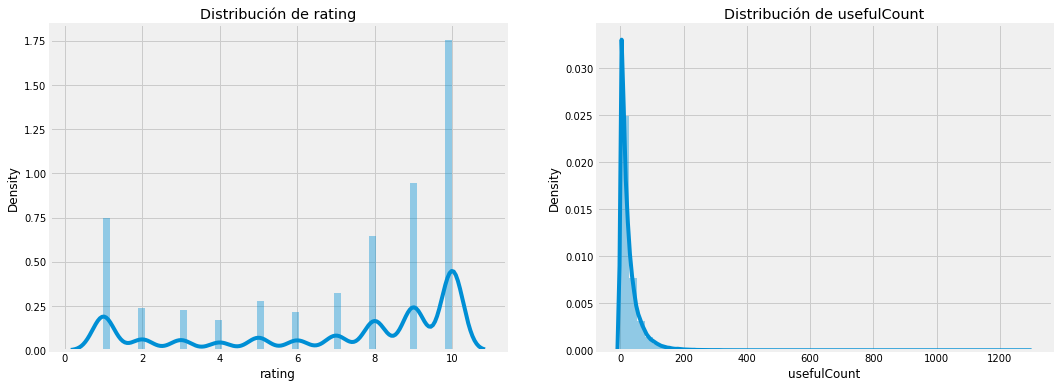

In [ ]:
# Revisamos distribución e histogramas para Rating y UsefulCount
figure, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].set_title('Distribución de rating')
sns.distplot(df['rating'], ax=ax[0])
ax[1].set_title('Distribución de usefulCount')
sns.distplot(df['usefulCount'], ax=ax[1])
plt.show()

Notemos que la mayoría de los 'useful count' se concentran en menos de 200 observaciones con una cola pesada a la derecha. En cuanto a 'rating' se observa que la mayoría de los 'review' se podrían considerar positivos (mayores a 7). 

### Gráficas relevantes de 'condition' y 'drugName'

<AxesSubplot:title={'center':'Padecimientos más frecuentes'}, ylabel='Conteo'>

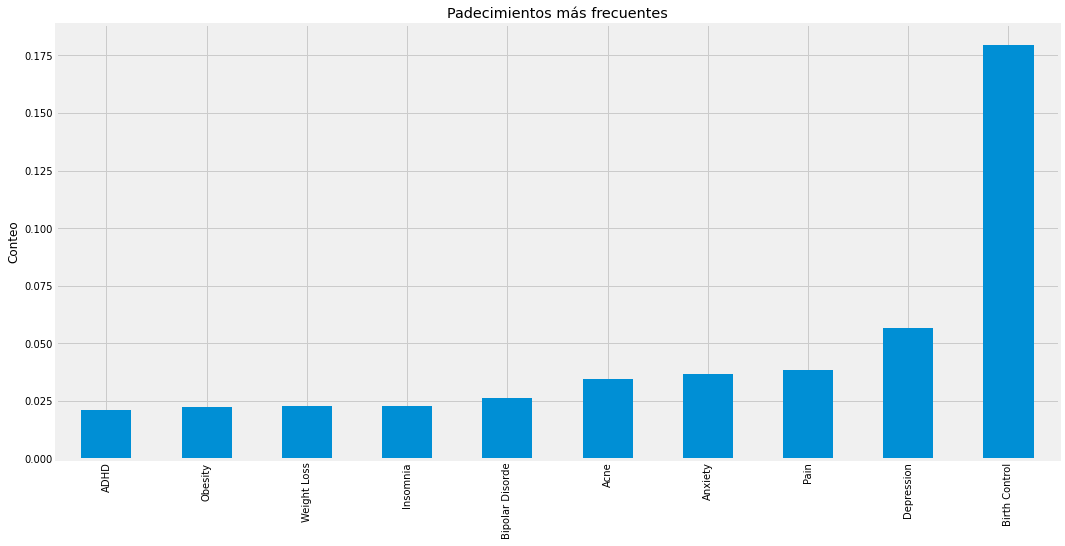

In [ ]:
#Condiciones más frecuentes 
df['condition'].value_counts(normalize=True, ascending=True).tail(10).plot(kind='bar', figsize=(16,8),
                                title='Padecimientos más frecuentes', ylabel='Conteo')

<AxesSubplot:title={'center':'Medicinas con mejores reviews'}, ylabel='Conteo'>

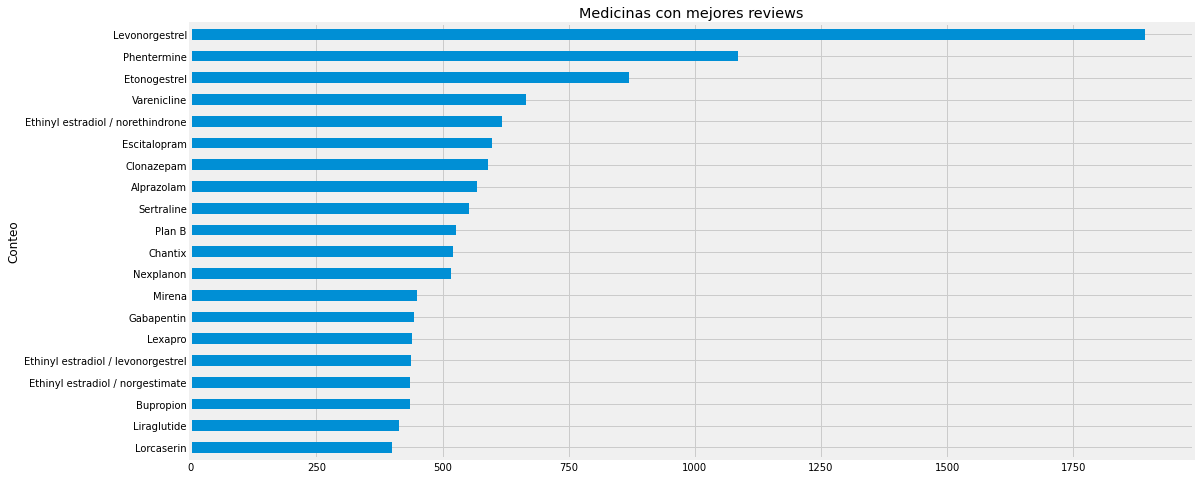

In [ ]:
df[df['rating']==10]['drugName'].value_counts(ascending=True).tail(20).plot(kind='barh', figsize=(16,8),
                                title='Medicinas con mejores reviews', ylabel='Conteo')

<AxesSubplot:title={'center':'Medicinas con peores reviews'}, ylabel='Conteo'>

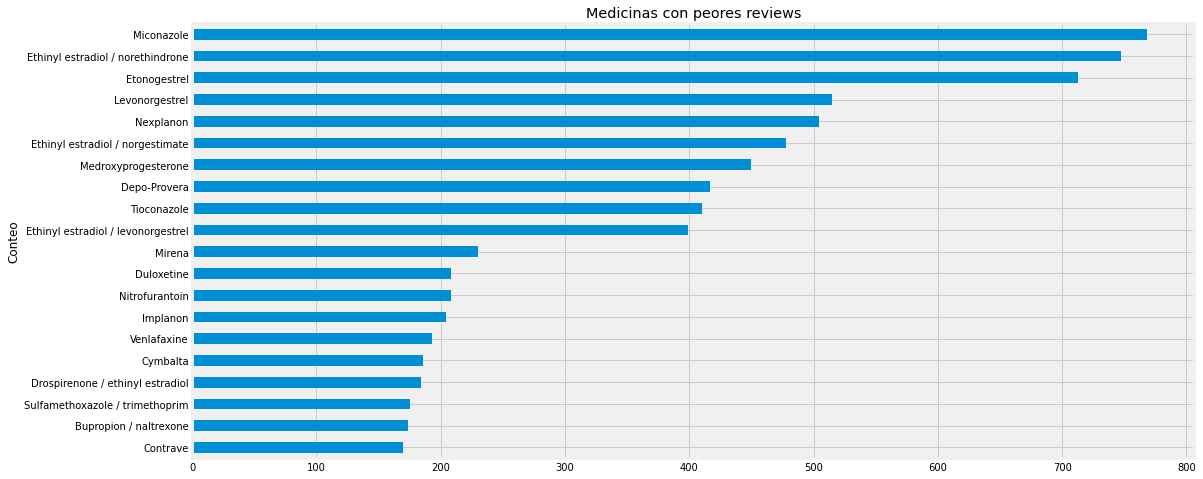

In [ ]:
df[df['rating']==1]['drugName'].value_counts(ascending=True).tail(20).plot(kind='barh', figsize=(16,8),
                                title='Medicinas con peores reviews', ylabel='Conteo')

### Wordclouds para 'reviews'

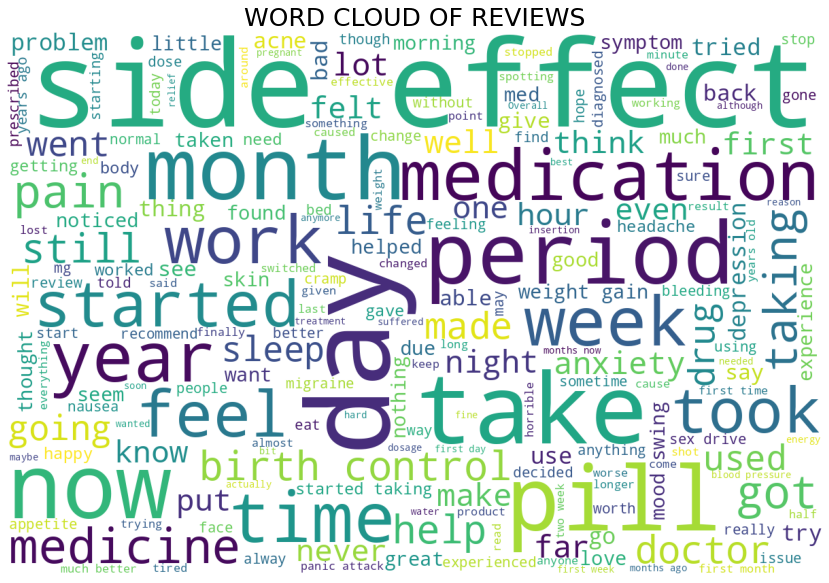

In [ ]:
general_reviews = " ".join([text for text in df['review']])

#Stopwords validas en WordCloud
stopwords = set(STOPWORDS)

wordcloud = WordCloud(background_color = 'white', stopwords = stopwords, 
                        width = 1200, height = 800).generate(general_reviews)

plt.rcParams['figure.figsize'] = (18, 10)
plt.title('WORD CLOUD OF REVIEWS', fontsize = 25)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

Wordcloud con reviews positivas

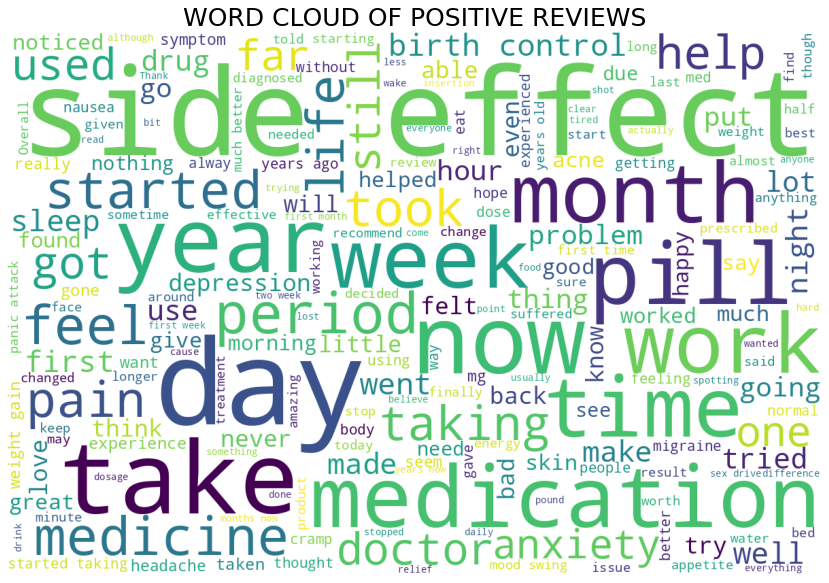

In [ ]:
#Stopwords validas en WordCloud
stopwords = set(STOPWORDS)
df_pos = df[df['rating']>=8]
positive_reviews = " ".join([text for text in df_pos['review']])
wordcloud = WordCloud(background_color = 'white', stopwords = stopwords, 
                        width = 1200, height = 800, collocations=True).generate(positive_reviews)

plt.rcParams['figure.figsize'] = (18, 10)
plt.title('WORD CLOUD OF POSITIVE REVIEWS', fontsize = 25)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

Wordcloud con reviews negativas

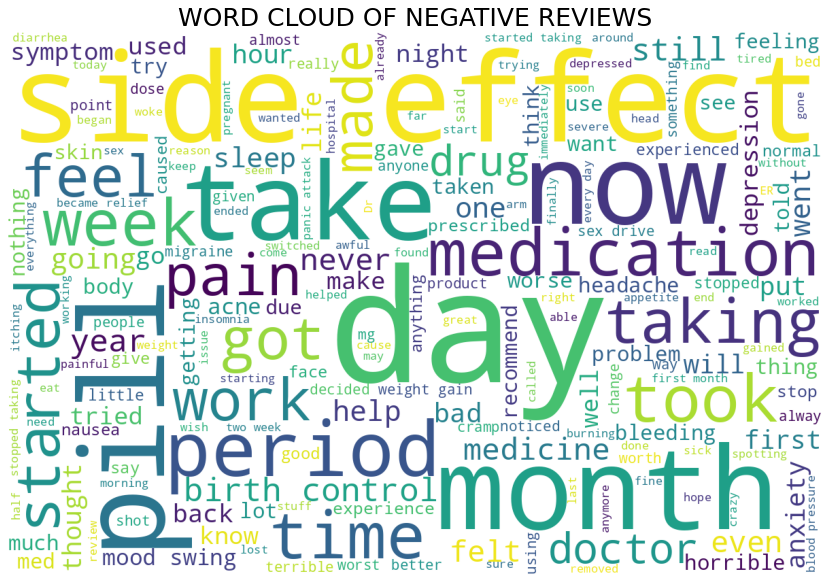

In [ ]:
#Stopwords validas en WordCloud
stopwords = set(STOPWORDS)
df_neg = df[df['rating']<=3]
negative_reviews = " ".join([text for text in df_neg['review']])
wordcloud = WordCloud(background_color = 'white', stopwords = stopwords, 
                        width = 1200, height = 800, collocations=True).generate(negative_reviews)

plt.rcParams['figure.figsize'] = (18, 10)
plt.title('WORD CLOUD OF NEGATIVE REVIEWS', fontsize = 25)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

## Preprocesamiento de Texto

Funciones para limpiar datos

Notamos que hay varias palabras redundantes que hasta llegan a ensuciar nuestro modelo, como puede ser el caso de 'months','great','years',etc. Por lo que vamos a hacer un corpus con estas palabras, para eliminarlas y obtener mejores clasificaciones.
Decimos que estas palabras son redundantes ya que son palabras que se pueden usar para cualquier padecimiento o problema, ya que por ejemplo esta "pills"(pastillas) y pues en todos los casos de nuestros datos se receta alguna medicina.

In [ ]:
pa_feas=['ability' ,'able', 'absolutely','actually', 'added', 'affect', 'affected', 'affects',
 'afford' ,'afraid' ,'afternoon','amazing','anymore','apply' ,'appointment', 'approximately' ,'april', 'area','asked','august', 'available','bathroom'
 ,'began', 'begin','beginning', 'believe','best' ,'better' ,'bigger','biggest','bought','brand','brought','called','came','case','cause',
 'caused' ,'causes' ,'causing','chance', 'change' ,'changed','changes' ,'changing', 'comes' ,'coming' ,'comments', 'common','compared','condition','continue', 'continued',
 'cost','course', 'cover' ,'covered','cure' ,'currently','days','deal' ,'dealing','december', 'decided' ,'decision', 'decrease' ,'decreased','difference'
, 'different' ,'differently','disease','doctors', 'dont', 'dosage' ,'dose' ,'doses','drop' ,'dropped','drugs','ease' ,'easier', 'easily' ,'easy',
'effect', 'effective', 'effectiveness','emergency','especially','eventually','everyday', 'exactly' ,'excellent' ,'excessive','experience',
 'experienced' ,'experiences', 'experiencing', 'extra', 'failed' ,'fairly','fantastic' ,'fast','february','figured','finally' ,'finding', 'fine','finish', 'finished',
 'form', 'forward', 'free' ,'function' ,'general', 'generally','gets' ,'getting' ,'given', 'gives',
 'giving','goes' ,'going', 'gone','happen', 'happened' ,'happens','health' ,'healthy','help' ,'helped' ,'helpful',
 'helping','history','hold' ,'home',
 'honestly' ,'hope', 'hopefully' ,'hoping','hospital','hour', 'hours', 'house', 'hurt' ,'hurts' ,'idea','important', 'improved', 'improvement' ,'including',
 'increase' ,'increased' ,'increasing' ,'incredibly','initial' ,'initially','instead','issue' ,'issues','january' ,'joint' ,'joints', 'july' ,'june' ,'keeping' ,'keeps' ,'kept','knew', 'know' ,'known',
 'late','later','leave' ,'left','likely','look',
 'looked' ,'looking' ,'looks','lots','luck' ,'lucky','main','major', 'make',
 'makes', 'making','march', 'market', 'matter',
 'maybe','mean', 'medical' ,'medications','medicine', 'medicines',
 'meds','mention' ,'mentioned','minimal' ,'minor', 'mins' ,'minute' ,'minutes', 'miracle','monday', 'money','month','months','moved', 'movement', 'moving' ,'multiple','near' ,'nearly', 
 'need',
 'needed' ,'needs', 'negative','normal',
 'normally','noticed' ,'november', 'number' ,'nurse','october',
 'office' ,'okay' ,'ones', 'online', 'open' ,'option','overall','pain','painful','pains','pass','passed','past','patient','people','perfect',
 'physical', 'pill', 'pills','place' ,'placed' ,'plan' ,'pleased' ,'plus',
 'point' ,'positive', 'possible' ,'post','prescribe' ,'prescribed' ,'prescription','prevent', 'previous', 'previously' ,'price', 'prior',
 'probably', 'problem', 'problems' ,'procedure', 'process' ,'product', 'pros','quality' ,'quick' ,'quickly',
 'quit' ,'quite' ,'quot', 'racing', 'random' ,'rarely','read', 'reading' ,'ready' ,'real' ,'realize', 'realized' ,'reason',
 'received','recommend', 'recommended', 'redness', 'reduce',
 'reduced','remember','result' ,'results' ,'return' ,'returned' ,'review' ,'reviews' ,'review', 'reviews','safe', 'said',
 'saying' ,'says','second' ,'seconds' ,'seeing',
 'seen','self' ,'send','september' ,'seriously','significant',
 'significantly', 'similar', 'single' ,'social', 'somewhat'
 ,'soon','start', 'started', 'starting', 'starts'
 ,'state', 'stay', 'stayed' ,'staying' , 'stop', 'stopped'
 ,'stopping' ,'stops', 'stories' ,'story','yesterday','year', 'wonder', 'wonderful' ,'wonders', 'working','world',
 'worried' ,'worry' ,'worse' ,'worst' ,'worth', 'write', 'wrong' ,'whatsoever' ,'went','want' ,'wanted', 'wanting','used','using',
 'usual', 'usually','understand' ,'unfortunately' ,'unless','type' ,'true','total' ,'totally' ,'treat' ,'treated','told', 'tolerable', 'tolerance' 'tolerate' 'tomorrow'
 ,'took','term' ,'terrible', 'test' ,'tests' ,'thank' ,'thankful' ,'thanks','time', 'times','today'
  ,'wait', 'waited','waiting','weeks','work', 'years']

pa_feas =list(set([wordnet_lemmatizer.lemmatize(word) for word in pa_feas]))
custom_stops=stop_words+pa_feas

In [ ]:
def remove_bi(series):
    """
        Recibe una serie y elimina palabras con pocas letras
        Parámetros
            series: Pandas.series
        Retorna
            Pandas.series sin palabras cortas
    """
    return series.apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

def Expand_contractions(series):
    """
        Recibe una serie y elimina contracciones (las expande)
        Parámetros
            series: Pandas.series
        Retorna
            Pandas.series con contracciones extendidas
    """
    return series.apply(lambda x: ' '.join([contractions.fix(word) for word in x.split()]))

def lemmatizeSeries(series):
    """
        Recibe una serie y lematiza las palabras por registro
        Parámetros
            series: Pandas.series
        Retorna
            Pandas.series lemmatizada
    """
    return series.apply(lambda x: ' '.join([wordnet_lemmatizer.lemmatize(word) for word in x.split()]))

def NewStops(series, stop=custom_stops):
    """
        Recibe una serie y quita stopwords
            series: Pandas.series
        Retorna
            Pandas.series con texto sin stopwords 
    """
    series=hero.remove_stopwords(series, stop)
    return(series)

def CleanData(data):
    """
        Recibe una serie y utiliza las funciones anteriores para realizar limpieza. 
        Parámetros
            series: Pandas.series
        Retorna
            Pandas.series con texto limpio 
    """
    my_pipeline=[Expand_contractions]+hero.get_default_pipeline()
    my_pipeline.append(remove_bi)
    my_pipeline.append(lemmatizeSeries)
    my_pipeline.append(NewStops)
    series=hero.clean(data, my_pipeline)
    return series

In [ ]:
df['sin_feas']=CleanData(df['review'])


## Extraer y visualizar los tópicos 

### Función para visualizar los modelos como wordclouds

In [ ]:
def draw_word_cloud(num_topics,model, title, vocab):
    #Sólo funciona con un número par de tópicos
    if title == "TruncatedSVD":
        model = model.components_ # components_ es la matriz VT
    elif title =="LDA":
        model = model.components_
    else:
        model = model
    if num_topics>2: 
        fig, ax = plt.subplots( ceil(num_topics/2),2, figsize=(10,ceil(num_topics/2)*5))
        for index in range(num_topics): 
            imp_words_topic=""
            comp = model[index]
            vocab_comp = zip(vocab, comp)
            sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:50]
            for word in sorted_words:
                imp_words_topic=imp_words_topic+" "+word[0]
            wordcloud = WordCloud(width=600, height=400, collocations=True).generate(imp_words_topic)
            ax[index//2][index%2].imshow(wordcloud)
            ax[index//2][index%2].axis("off")
            ax[index//2][index%2].set_title(f"Topic {index}")
    else: 
        fig, ax = plt.subplots(1,2, figsize = (10, 5))
        for index in range(2): 
            imp_words_topic=""
            comp = model[index]
            vocab_comp = zip(vocab, comp)
            sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:50]
            for word in sorted_words:
                imp_words_topic=imp_words_topic+" "+word[0]
            wordcloud = WordCloud(width=600, height=400, collocations=True).generate(imp_words_topic)
            ax[index].imshow(wordcloud)
            ax[index].axis("off")
            ax[index].set_title(f"Topic {index}")
    plt.show()

### Tópicos con todos los datos

In [ ]:
#Visualización rápida de los datos
df['sin_feas'].head()

0                 side  take combination bystolic fish
1    halfway fourth  intuniv became concerned  last...
2     take another oral contraceptive  cycle happy ...
3    first    birth control glad  patch  first  lib...
4    suboxone completely turned life around feel he...
Name: sin_feas, dtype: object

In [ ]:
#Construyendo el TFIDF para los reviews. 
vectorizer = TfidfVectorizer(stop_words='english',
                            max_features= 1000,
                            max_df = 0.7,
                            min_df= 0.05,  
                            smooth_idf=True)
X = vectorizer.fit_transform(df['sin_feas'])
terminos= vectorizer.get_feature_names_out()
vocab = vectorizer.get_feature_names()

In [ ]:
#Análisis de la versión truncada de SVD
from sklearn.decomposition import TruncatedSVD
svd_model = TruncatedSVD(n_components=10, #Dimensionalidad deseada de los datos de salida.
                         algorithm='randomized', 
                         n_iter=100, random_state=122)
svd_model_top = svd_model.fit_transform(X)

In [ ]:
#Palabras más importantes de cada tópico
for i, comp in enumerate(svd_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

Topic 0: 
taking like feel period life weight really anxiety felt good 

Topic 1: 
period control birth weight bleeding acne cramp gain mood love 

Topic 2: 
taking period birth control weight acne bleeding cramp gain lost 

Topic 3: 
life anxiety depression tried worked severe sleep great weight night 

Topic 4: 
night sleep great worked good morning tried really weight headache 

Topic 5: 
weight great lost gain feel good anxiety worked depression mood 

Topic 6: 
great worked tried really skin like acne life gave thing 

Topic 7: 
anxiety depression great period feel severe symptom feeling control mood 

Topic 8: 
great feel life sleep night period bleeding love taking morning 

Topic 9: 
good really feel period thing life little think cramp long 



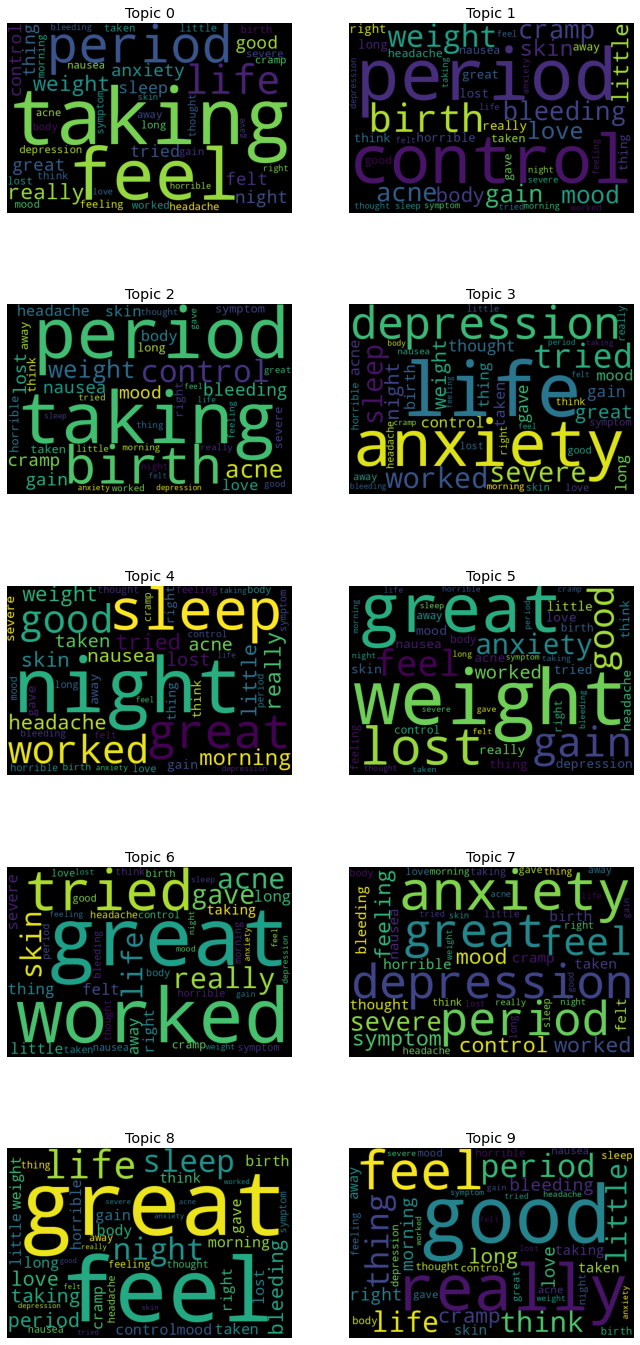

In [ ]:
#Visualización de tópicos
draw_word_cloud(10, svd_model, "TruncatedSVD", vocab)

In [ ]:
#Cálculo de SVD usando randomized_svd
U, Sigma, VT = randomized_svd(X, 
                              n_components=10, #Dimensionalidad deseada de los datos de salida.
                              n_iter=100,
                              random_state=122)

In [ ]:
#Palabras más importantes de cada tópico
for i, comp in enumerate(VT):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

Topic 0: 
taking like feel period life weight really anxiety felt good 

Topic 1: 
period control birth weight bleeding acne cramp gain mood love 

Topic 2: 
taking period birth control weight acne bleeding cramp gain lost 

Topic 3: 
life anxiety depression tried worked severe sleep great weight night 

Topic 4: 
night sleep great worked good morning tried really weight headache 

Topic 5: 
weight great lost gain feel good anxiety worked depression mood 

Topic 6: 
great worked tried really skin like acne life gave thing 

Topic 7: 
anxiety depression great period feel severe symptom feeling control mood 

Topic 8: 
great feel life sleep night period bleeding love taking morning 

Topic 9: 
good really feel period thing life little think cramp long 



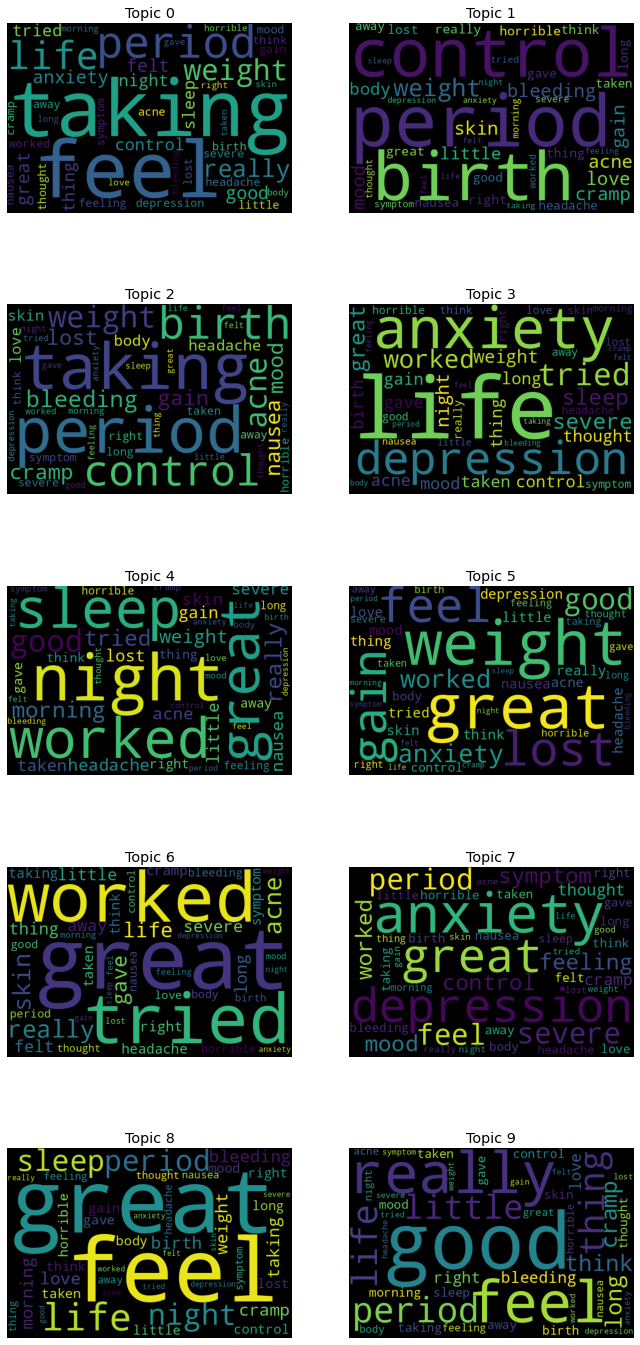

In [ ]:
#Visualización de tópicos
draw_word_cloud(10, VT, "VT", vocab)

### Tópicos de sentimiento positivo y negativo

In [ ]:
#Seleccionamos solo los tópicos con información de reviews con 
#mayor polaridad
df_sent = df[(df['rating']<=3)| (df['rating']>=8)]

In [ ]:
#Construimos el Tfidf para el dataset cortado
vectorizer = TfidfVectorizer(stop_words='english',
                            max_features= 1000,
                            max_df = 0.7,
                            min_df= 0.05,  
                            smooth_idf=True)
X = vectorizer.fit_transform(df_sent['sin_feas'])
terminos= vectorizer.get_feature_names_out()
vocab = vectorizer.get_feature_names()

In [ ]:
#Análisis de la versión truncada de SVD
from sklearn.decomposition import TruncatedSVD
svd_model = TruncatedSVD(n_components=2, #Dimensionalidad deseada de los datos de salida.
                         algorithm='randomized', 
                         n_iter=100, random_state=122)
svd_model_top = svd_model.fit_transform(X)

In [ ]:
#Palabras más importantes de cada tópico
for i, comp in enumerate(svd_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

Topic 0: 
taking like feel period life anxiety weight really felt great 

Topic 1: 
period control birth weight cramp acne gain mood love skin 



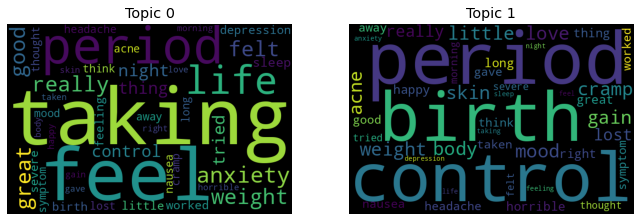

In [ ]:
#Visualización de tópicos
draw_word_cloud(2, svd_model, "TruncatedSVD", vocab)

In [ ]:
#Cálculo de SVD usando randomized_svd
U, Sigma, VT = randomized_svd(X, 
                              n_components=2, #Dimensionalidad deseada de los datos de salida.
                              n_iter=100,
                              random_state=122)

In [ ]:
#Palabras más importantes de cada tópico
for i, comp in enumerate(VT):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

Topic 0: 
taking like feel period life anxiety weight really felt great 

Topic 1: 
period control birth weight cramp acne gain mood love skin 



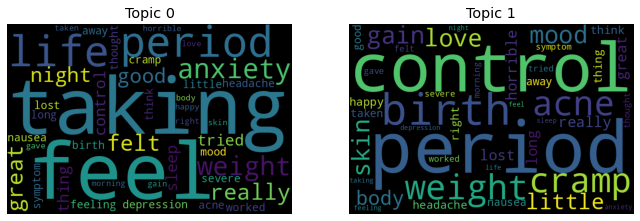

In [ ]:
#Visualización de tópicos
draw_word_cloud(2, VT, "VT", vocab)

#### Otra alternativa con LDA

In [ ]:
# Construcción del modelo de LDA
lda_model = LatentDirichletAllocation(n_components=2, max_iter=10, learning_method='online')
lda_Z = lda_model.fit_transform(X)

In [ ]:
#Palabras más importantes de cada tópico
for i, comp in enumerate(lda_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

Topic 0: 
period taking weight control little headache symptom acne lost birth 

Topic 1: 
like feel life great anxiety good night tried felt worked 



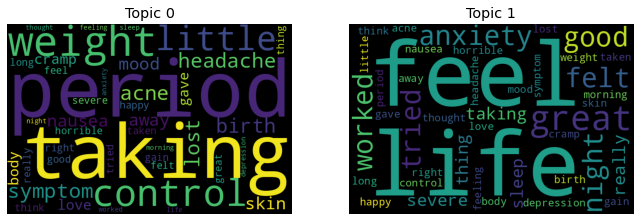

In [ ]:
#Visualización de tópicos
draw_word_cloud(2, lda_model, "LDA", vocab)

In [ ]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, X, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=               x           y  topics  cluster       Freq
topic                                                   
1     -60.312317  141.369629       1        1  54.487675
0      60.312561 -141.369141       2        1  45.512325, topic_info=       Term          Freq         Total Category  logprob  loglift
28   period  12572.000000  12572.000000  Default  30.0000  30.0000
41   weight   9622.000000   9622.000000  Default  29.0000  29.0000
8      feel  12141.000000  12141.000000  Default  28.0000  28.0000
18     life  10901.000000  10901.000000  Default  27.0000  27.0000
5   control   7504.000000   7504.000000  Default  26.0000  26.0000
..      ...           ...           ...      ...      ...      ...
38    think     83.623354   5046.048474   Topic2  -7.4116  -3.3129
21     long     10.978779   5020.772085   Topic2  -9.4419  -5.3382
14    great     11.654189   8726.628099   Topic2  -9.3822  -5.8313
13     good      5.004016   8189.769632   Topic2 -10.2276  -6.6132
31   severe      1.965788   6480.944392   Topic2 -11.1620  -7.3135

[92 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.000166     acne
0         2  0.999910     acne
1         1  0.999971  anxiety
1         2  0.000118  anxiety
2         1  0.000175     away
...     ...       ...      ...
40        2  0.000129    tried
41        1  0.000104   weight
41        2  0.999899   weight
42        1  0.999897   worked
42        2  0.000137   worked

[86 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

### Tópicos analizando los 31 padecimientos más comunes*

A continuación, elegimos los 31 padecimientos más comunes para realizar un modelado de tópicos sobre las reseñas correspondientes a estas condiciones. Se decidió eliminar la condición más común "birth control" pues era tan frecuente que desbalanceaba de manera importante la muestra. 

Esta selección nos dejó con un total de 108,512 registros (documentos) que representan un poco más del 50% de los datos totales.

In [ ]:
# Número de condiciones distintas
df['condition'].nunique()

916

In [ ]:
# Porcentaje de los datos perteneientes a las 31 condiciones más frecuentes
df.groupby('condition').count().sort_values(by='drugName', ascending=False).iloc[1:32].sum()/215063

drugName       0.504559
review         0.504559
rating         0.504559
date           0.504559
usefulCount    0.504559
sin_feas       0.504559
dtype: float64

In [ ]:
df.groupby('condition').count().sort_values(by='drugName', ascending=False).iloc[1:32].index

Index(['Depression', 'Pain', 'Anxiety', 'Acne', 'Bipolar Disorde', 'Insomnia',
       'Weight Loss', 'Obesity', 'ADHD', 'Diabetes, Type 2',
       'Emergency Contraception', 'High Blood Pressure',
       'Vaginal Yeast Infection', 'Abnormal Uterine Bleeding',
       'Bowel Preparation', 'Smoking Cessation', 'ibromyalgia', 'Migraine',
       'Anxiety and Stress', 'Major Depressive Disorde', 'Constipation',
       'Chronic Pain', 'Panic Disorde', 'Migraine Prevention',
       'Urinary Tract Infection', 'Muscle Spasm', 'Osteoarthritis',
       'Generalized Anxiety Disorde', 'Opiate Dependence',
       'Erectile Dysfunction', 'Irritable Bowel Syndrome'],
      dtype='object', name='condition')

De manera manual agrupamos las condiciones que eran relacionadas. De esta manera determinamos un número de tópicos a usar para el modelado de tópicos.

In [ ]:
sexual_reproductive = ['Vaginal Yeast Infection','Emergency Contraception','Erectile Dysfunction',
                        'Abnormal Uterine Bleeding', 'Urinary Tract Infection']

mental = ['Depression','Bipolar Disorde', 'ADHD', 'Major Depressive Disorde', 'Generalized Anxiety Disorde',
           'Anxiety', 'Anxiety and Stress','Panic Disorde']

weight_digestive = ['Weight Loss', 'Diabetes, Type 2', 'Obesity', 'Bowel Preparation', 
                    'Irritable Bowel Syndrome', 'Constipation']

muscles_bones = ['ibromyalgia', 'Muscle Spasm','Osteoarthritis']

neurological = ['Insomnia','Migraine','Migraine Prevention']

adictions = ['Smoking Cessation', 'Opiate Dependence']

pain = ['Pain', 'Chronic Pain']

others = ['Acne', 'High Blood Pressure']

# Conjunto de condiciones a usar
subset = list(df.groupby('condition').count().sort_values(by='drugName', ascending=False).iloc[1:32].index)

In [ ]:
# Creamos la muestra con los registros pertenecientes a las condiciones seleccionadas
selected_index = []
for i in range(len(df)):
  if df['condition'].iloc[i] in subset:
    selected_index.append(i)
    
df_sub = df.iloc[selected_index]

In [ ]:
# ---------------------- TFidF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', 
                            max_features= 1000, # máximo número de términos
                            max_df = 0.60,
                            min_df=2,  
                            smooth_idf=True)

X = vectorizer.fit_transform(df_sub['sin_feas'])
print("Tamaño de la matriz TD-IDF: ", X.shape) # visualizamos el tamaño de la matriz

## Visualizando los términos obtenidos con TfidfVectorizer
terminos = vectorizer.get_feature_names_out()
print("Total de términos:", len(terminos))


# ------------------------ Truncated SVD -----------------------
svd_model = TruncatedSVD(n_components=8, #Dimensionalidad deseada de los datos de salida.
                         algorithm='randomized', 
                         n_iter=100, random_state=122)
svd_model.fit_transform(X)


# ------------------------ Randomized SVD ------------------------
from sklearn.utils.extmath import randomized_svd
U, Sigma, VT = randomized_svd(X, 
                              n_components=8, #Dimensionalidad deseada de los datos de salida.
                              n_iter=100,
                              random_state=122)

Tamaño de la matriz TD-IDF:  (108512, 1000)
Total de términos: 1000


Usamos 8 tópicos y visualizamos las nubes de palabras correspondientes a cada uno de los tópicos.

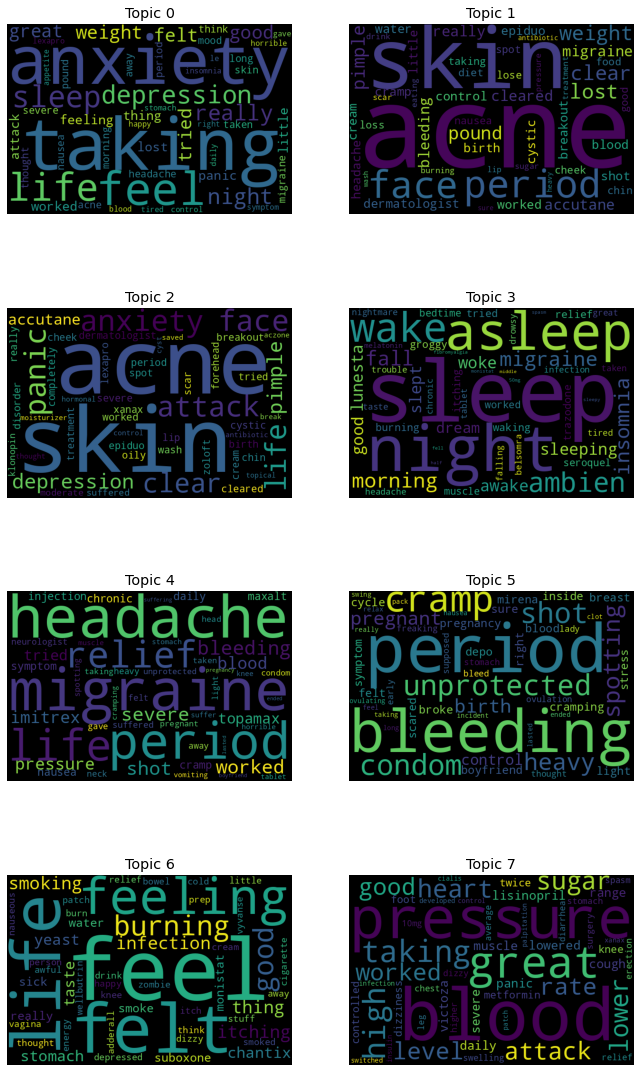

In [ ]:
draw_word_cloud(8, svd_model, "TruncatedSVD", terminos)

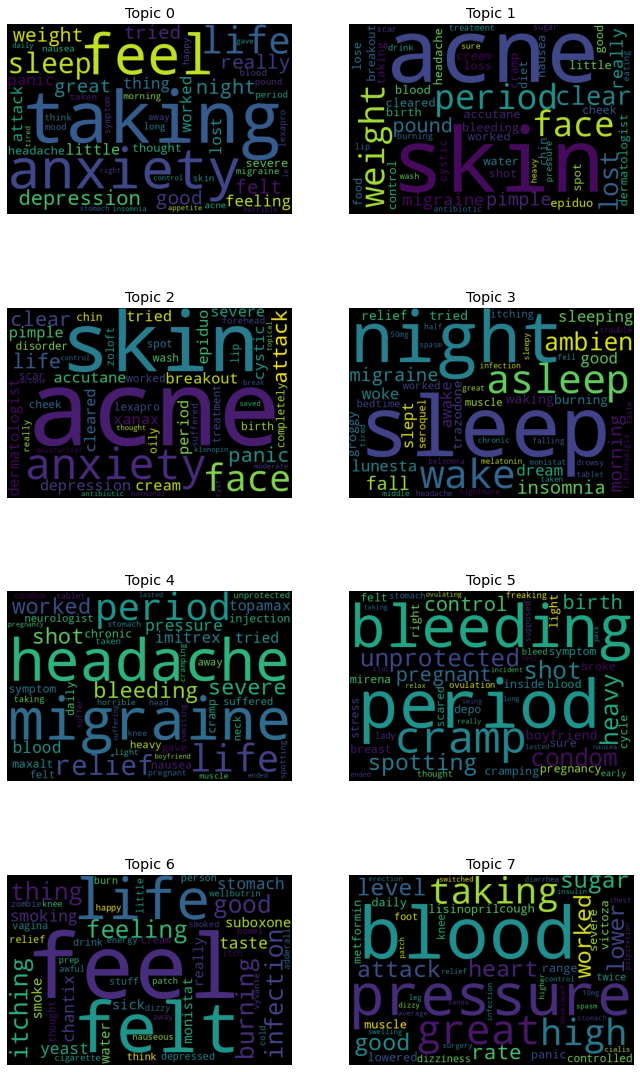

In [ ]:
draw_word_cloud(8, VT, "Randomized SVD", terminos)

### Tópicos analizando Bigramas

In [ ]:
def Bigram(series):
    Cvectorizer = TfidfVectorizer(ngram_range=(2,2),
                                max_features= 1000,
                                max_df = 0.95,
                                min_df=2)                        
    X = Cvectorizer.fit_transform(series)
    terminos= Cvectorizer.get_feature_names_out()
    return(X , terminos)

X_bi, terminos_bi = Bigram(df['sin_feas'])


In [ ]:
from sklearn.decomposition import TruncatedSVD
svd_model = TruncatedSVD(n_components=10, #Dimensionalidad deseada de los datos de salida.
                         algorithm='randomized', 
                         n_iter=100, random_state=122)
svd_model.fit_transform(X_bi)


array([[ 4.38782393e-03,  6.09772943e-03,  1.68388892e-03, ...,
         7.03248399e-03, -1.51730691e-03,  1.32847061e-03],
       [ 1.68618472e-02,  1.15017079e-02,  4.41624883e-04, ...,
         1.77157135e-02, -5.17360420e-04,  4.34459163e-03],
       [ 3.71546366e-02,  1.42756373e-03,  4.33903386e-03, ...,
         5.82853949e-03, -6.28961262e-04,  5.41290832e-03],
       ...,
       [ 1.54196344e-02,  1.48188711e-02, -2.26468742e-04, ...,
         8.00369318e-03, -1.54107654e-03,  6.74032733e-03],
       [ 5.29592888e-04,  1.77555522e-03, -1.98180896e-05, ...,
         1.36899988e-03,  1.47745542e-03,  1.55558082e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [ ]:

def show_topics2(model, terminos, num_top_words):
    top_words = lambda t: [terminos[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in model])
    for k in range(len(topic_words)):
        print('Tópico {}:'.format(k))
        print(*topic_words[k][:5], sep=', ')
        print(*topic_words[k][5:], sep=', ')
        print("\n")

print('Top 10 topics, described by top bigrams in each topic\n')
show_topics2(svd_model.components_, terminos_bi, 10)

Top 10 topics, described by top bigrams in each topic

Tópico 0:
birth control, weight gain, mood swing, feel like, gained weight
gained pound, first birth, gain weight, felt like, taking birth


Tópico 1:
feel like, blood pressure, weight gain, panic attack, felt like
made feel, mood swing, like person, life back, high blood


Tópico 2:
weight gain, blood pressure, mood swing, high blood, side weight
gained pound, gain mood, gain acne, hair loss, acne weight


Tópico 3:
blood pressure, high blood, birth control, heart rate, felt like
lost pound, weight loss, panic attack, worked well, worked great


Tópico 4:
panic attack, felt like, mood swing, anxiety panic, saved life
depression anxiety, panic disorder, anxiety depression, life back, severe anxiety


Tópico 5:
mood swing, swing depression, gained weight, horrible mood, crazy mood
severe mood, blood pressure, depression mood, period mood, swing weight


Tópico 6:
felt like, yeast infection, worked well, first felt, lost pound
weight

### Conclusión

Notamos que este proyecto puede servir bastante para poder hacer análisis de información médica y sobre todo nos sirve para poder automatizar consultas medicas y poder predecir enfermedades y medicinas para recetar  cuando se conocen las palabras más utilizadas por pacientes que tienen estas enfermedades y utilizan estas medicinas.

Además, también el análisis de sentimientos permite identificar la percepción de los consumidores sobre los medicamentos y si estos fueron efectivos para tratar el malestar o no. Esta fue una buena oportunidad para probar otros métodos de selección de tópicos como LDA y ver que dependiendo la situación un modelo u otro clasifica mejor. 

También, notamos que el análisis a partir de los bigramas permite dar un poco más de contexto a los términos frecuentes lo que nos permite extraer información más precisa y enriquecer el entendimiento de los tópicos.

Por otro lado notamos que aunque hayamos quitado stop words hay bastantes palabras que se repiten a lo largo de los distintos tópicos lo que hace más complicado poder hacer buenos análisis, estas palabras eran bastante redundantes y podían aplicarse a muchos diagnósticos, por lo que se tuvo que hacer una limpieza de estas y se obtuvieron mejores resultados.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c4e0002e-2555-42af-890c-6669f63ba0e4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>